  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
--- 1. ЗАВАНТАЖЕННЯ ДАНИХ ---
Назви колонок:
['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'brand_in_subdomain',

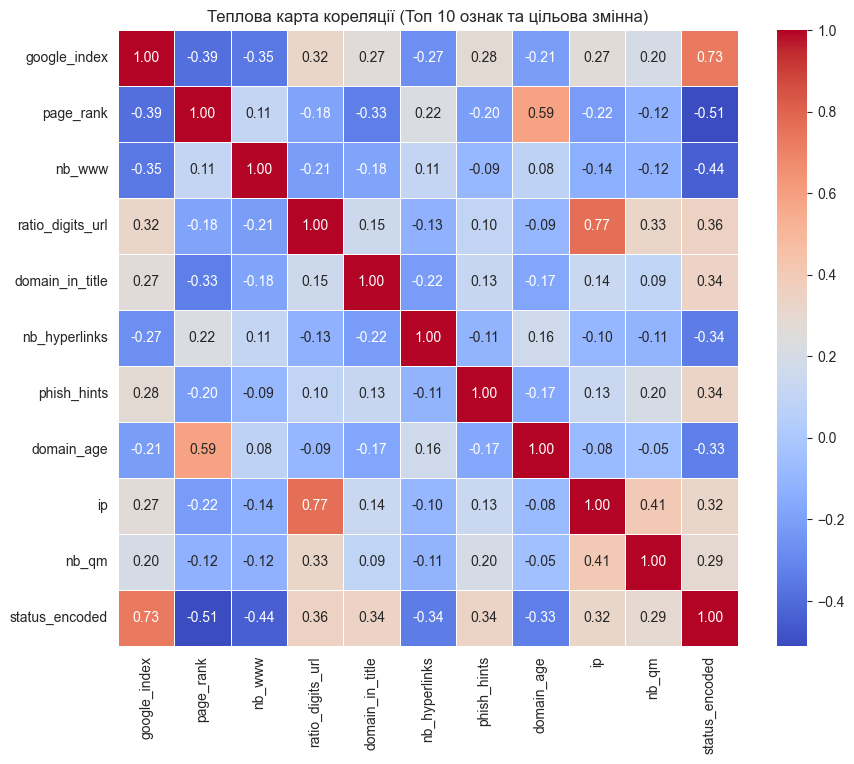

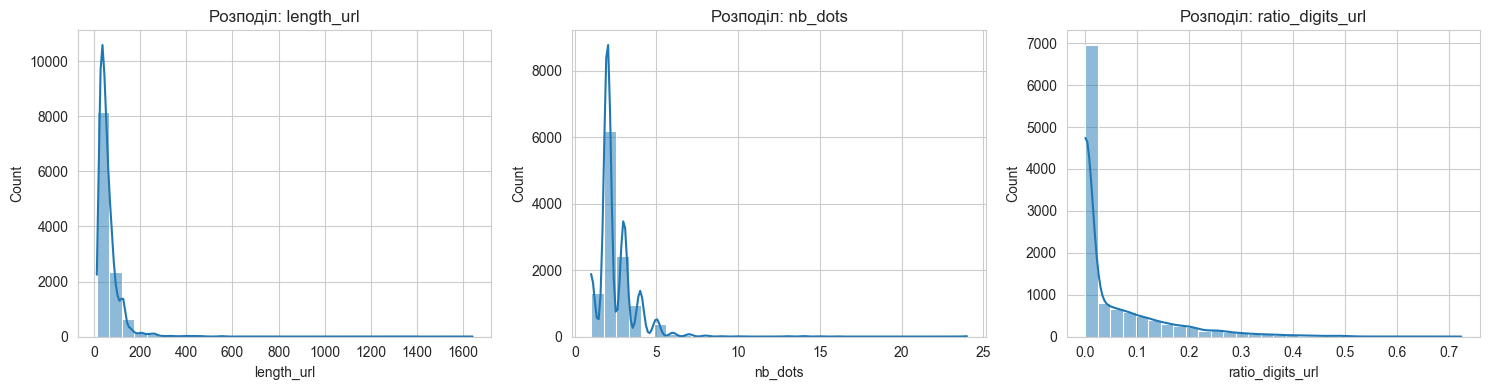

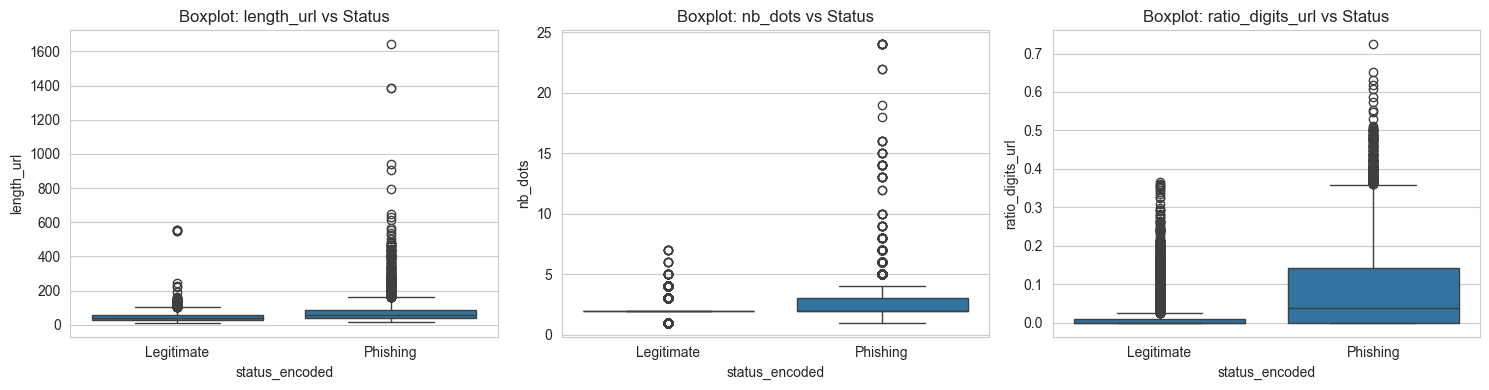


--- 4. НОРМАЛІЗАЦІЯ ДАНИХ ---
✅ Дані нормалізовано (MinMaxScaler) та розділено на тренувальний (70%) і тестовий (30%) набори.

--- 5. НАВЧАННЯ ТА ОПТИМІЗАЦІЯ КЛАСИФІКАТОРІВ ---

[5.1] kNN: Підбір оптимального k...

--- kNN (k=3) (Accuracy: 0.9274) ---
Час прогнозування: 0.0527 сек.

Classification Report (sklearn.metrics.classification_report):
                precision    recall  f1-score   support

Legitimate (0)       0.92      0.94      0.93      1715
  Phishing (1)       0.94      0.92      0.93      1714

      accuracy                           0.93      3429
     macro avg       0.93      0.93      0.93      3429
  weighted avg       0.93      0.93      0.93      3429


Confusion Matrix (sklearn.metrics.confusion_matrix):
[[1610  105]
 [ 144 1570]]
Оптимальне k для kNN: 3

[5.2] Decision Tree: Навчання...

--- Decision Tree (Accuracy: 0.9376) ---
Час прогнозування: 0.0022 сек.

Classification Report (sklearn.metrics.classification_report):
                precision    recall  

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import sys
!{sys.executable} -m pip install tabulate
# Встановлення стилю для кращої візуалізації
sns.set_style("whitegrid")

# --- 1. Завантаження даних, назви колонок і розмір датасету ---
print("--- 1. ЗАВАНТАЖЕННЯ ДАНИХ ---")
FILE_NAME = "dataset_phishing.csv"

try:
    df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"Помилка: Файл '{FILE_NAME}' не знайдено. Переконайтеся, що файл завантажено.")
    # Якщо файл не знайдено, використовуємо пошук (хоча в цьому сценарії це не потрібно,
    # оскільки файл було надано через chat context, але для локального запуску це важливо)
    exit()

print("Назви колонок:")
print(df.columns.tolist())
print("\nРозмір датасету (рядки, стоввпці):")
print(df.shape)

# Видалення колонки 'url' та кодування цільової змінної
df_processed = df.drop(columns=['url'])
le = LabelEncoder()
df_processed['status_encoded'] = le.fit_transform(df_processed['status'])
df_processed = df_processed.drop(columns=['status'])
TARGET_COLUMN = 'status_encoded'

# --- 2. Опрацювання пропусків ---
print("\n" + "=" * 50)
print("--- 2. ОПРАЦЮВАННЯ ПРОПУСКІВ ---")
missing_values = df_processed.isnull().sum()
missing_values = missing_values[missing_values > 0]

if missing_values.empty:
    print("✅ Пропущених значень немає. Додаткове опрацювання не потрібне.")
else:
    print("❌ Знайдено пропущені значення:")
    print(missing_values)
    # Якщо є пропуски: df_processed = df_processed.fillna(df_processed.median()) або df_processed.dropna()
    df_processed.dropna(inplace=True)  # Видаляємо рядки з пропусками, якщо вони є.

# --- 3. Візуалізація даних ---
print("\n" + "=" * 50)
print("--- 3. ВІЗУАЛІЗАЦІЯ ДАНИХ ---")

# 3.1. Кореляційна матриця (Heatmap)
# Вибір 10 ознак з найбільшою абсолютною кореляцією до цільової змінної
correlations = df_processed.corr()[TARGET_COLUMN].abs().sort_values(ascending=False)
top_features = correlations[1:11].index.tolist()
features_to_plot = top_features + [TARGET_COLUMN]
corr_matrix = df_processed[features_to_plot].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Теплова карта кореляції (Топ 10 ознак та цільова змінна)')
plt.show()

# 3.2. Гістограми розподілу та Boxplots
selected_features_viz = ['length_url', 'nb_dots', 'ratio_digits_url']

# Гістограми розподілу
plt.figure(figsize=(15, 4))
for i, feature in enumerate(selected_features_viz):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df_processed[feature], kde=True, bins=30)
    plt.title(f'Розподіл: {feature}')
plt.tight_layout()
plt.show()

# Boxplots ознак відносно цільової змінної (0=legitimate, 1=phishing)
plt.figure(figsize=(15, 4))
for i, feature in enumerate(selected_features_viz):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x=TARGET_COLUMN, y=feature, data=df_processed)
    plt.xticks([0, 1], ['Legitimate', 'Phishing'])
    plt.title(f'Boxplot: {feature} vs Status')
plt.tight_layout()
plt.show()

# --- 4. Нормалізація даних ---
print("\n" + "=" * 50)
print("--- 4. НОРМАЛІЗАЦІЯ ДАНИХ ---")

# Відокремлення ознак (X) та цільової змінної (y)
X = df_processed.drop(columns=[TARGET_COLUMN])
y = df_processed[TARGET_COLUMN]

# Розбиття на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ініціалізація та застосування MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Перетворення назад у DataFrame (для зручності)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✅ Дані нормалізовано (MinMaxScaler) та розділено на тренувальний (70%) і тестовий (30%) набори.")

# --- 5. Навчання класифікаторів та підбір оптимальних параметрів ---
print("\n" + "=" * 50)
print("--- 5. НАВЧАННЯ ТА ОПТИМІЗАЦІЯ КЛАСИФІКАТОРІВ ---")

best_models = {}


def evaluate_and_store(model, model_name, X_test, y_test):
    """Оцінка моделі та виведення метрик."""
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()

    accuracy = accuracy_score(y_test, y_pred)
    best_models[model_name] = {'model': model, 'accuracy': accuracy}

    print(f"\n--- {model_name} (Accuracy: {accuracy:.4f}) ---")
    print(f"Час прогнозування: {end_time - start_time:.4f} сек.")
    print("\nClassification Report (sklearn.metrics.classification_report):")
    print(classification_report(y_test, y_pred, target_names=['Legitimate (0)', 'Phishing (1)']))
    print("\nConfusion Matrix (sklearn.metrics.confusion_matrix):")
    # Матриця має вигляд: [[TN, FP], [FN, TP]]
    print(confusion_matrix(y_test, y_pred))

    return accuracy


# 5.1. kNN (k-Nearest Neighbors) - Підбір k
print("\n[5.1] kNN: Підбір оптимального k...")
k_range = range(1, 16)
k_scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k, n_jobs=-1), X_train_scaled, y_train, cv=3,
                            scoring='accuracy').mean() for k in k_range]
optimal_k = k_range[np.argmax(k_scores)]

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=-1)
knn_optimal.fit(X_train_scaled, y_train)
knn_accuracy = evaluate_and_store(knn_optimal, f"kNN (k={optimal_k})", X_test_scaled, y_test)
print(f"Оптимальне k для kNN: {optimal_k}")

# 5.2. Decision Tree (Дерево ухвалення рішень)
print("\n[5.2] Decision Tree: Навчання...")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_accuracy = evaluate_and_store(dt_model, "Decision Tree", X_test_scaled, y_test)

# 5.3. SVM (Support Vector Machine) - GridSearch для C та gamma
print("\n[5.3] SVM: GridSearch для C та gamma...")
param_grid_svm = {
    'C': [0.1, 1],
    'gamma': ['scale', 0.1],
    'kernel': ['rbf']
}

# Використання підмножини даних для GridSearch (приблизно 20% від тренувального)
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train_scaled, y_train, test_size=0.8, random_state=42, stratify=y_train
)

# Налаштування GridSearch
grid_search_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=2, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train_subset, y_train_subset)

svm_optimal = grid_search_svm.best_estimator_
svm_accuracy = evaluate_and_store(svm_optimal, "Optimal SVM (RBF)", X_test_scaled, y_test)
print(f"Оптимальні параметри SVM: {grid_search_svm.best_params_}")

# 5.4. Random Forest
print("\n[5.4] Random Forest: Навчання...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_accuracy = evaluate_and_store(rf_model, "Random Forest", X_test_scaled, y_test)

# 5.5. AdaBoost
print("\n[5.5] AdaBoost: Навчання...")
base_estimator = DecisionTreeClassifier(max_depth=1)
ada_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=42)
ada_model.fit(X_train_scaled, y_train)
ada_accuracy = evaluate_and_store(ada_model, "AdaBoost", X_test_scaled, y_test)

# --- 6. Вибір найкращої моделі ---
print("\n" + "=" * 50)
print("--- 6. ПОРІВНЯННЯ РЕЗУЛЬТАТІВ ТА ВИБІР НАЙКРАЩОЇ МОДЕЛІ ---")

results_df = pd.DataFrame({
    'Модель': list(best_models.keys()),
    'Accuracy': [model['accuracy'] for model in best_models.values()]
}).sort_values(by='Accuracy', ascending=False)

print("\nЗведена таблиця результатів:")
print(results_df.to_markdown(index=False))

# Вибір найкращої моделі
best_model_name = results_df.iloc[0]['Модель']
best_model_accuracy = results_df.iloc[0]['Accuracy']

print(f"\n--- ⭐ НАЙКРАЩА МОДЕЛЬ: {best_model_name} (Accuracy: {best_model_accuracy:.4f}) ⭐ ---")

print("\n✅ Завдання виконано повністю.")